# Условие

Дан набор строк в количестве $50000\leq n\leq 500000$. Необходимо оценить количество уникальных строк с точностью не менее 95%, используя не более 500 КБ оперативной памяти. Гарантируется, что ответ от $50000$ до $100000$.

# Решение

## Стандартные решения через сет

Использование обычного сета строк не поможет, так как объём занимаемой памяти будет явно больше 500 КБ. Поможет ли хранение хэшей строк вместо самих строк? Один хэш - это даже не 4 байта, а 28 (так как 24 байта у каждого объекта типа int в питоне нужно для хранения метаданных, типа ссылок, информации о типе и прочего) + 8 байт для хранения ссылок в хэш таблице сета. Тогда максимальный потенциальный объем сета будет 36 Б *  100000 = 3515.625 КБ. Плюс надо учитывать, что сеты заполняются не более, чем на 2/3 от общего размера, так что объем становится 5273.4375 КБ. Это больше, чем задача разрешает, и вообще, так как так как задача явно не на алгоритмы и не на загонение решения в ограничения, а на ML и все с ним связанное, будем решать в этом же стиле.

## Что используем в итоге и литература по способам

Для решения можно использовать вероятностные структуры данных (probabilistic data structures). Для такой задачи существуют такие структуры, как HyperLogLog и LinearCounting. HyperLogLog лучше себя показывает на большом количестве данных, а LinearCounting на малом. В идеале совмещать эти способы. Больше почитать об этих способах и их совмещении можно здесь https://habr.com/ru/companies/vk/articles/711126/ (человек применял эти методы для подсчета количества уникальных пользователей, посмотревших пост), здесь https://habr.com/ru/articles/119852/ и здесь https://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf.

## Разбор решения

### Общее понимание HyperLogLog

За HyperLogLog стоит сложная математика, но общая суть такова. Посчитаем хэш данных. Для строк хэш можно считать как, например, полином по модулю:
$$
hash(s)=(s_0k^0+s_1k^1+...+s_nk^n)\ mod\ p
$$
где $s$ - строка длиной $n$, $s_i$ - символ строки, представленный в виде числа (почти всегда как код символа в текущей кодировке), $p$ - модуль, который нужен для ограничения размера числа, чтобы оно влезло в int.
<br>
Можно видеть, что $p$ также ограничивает количество возможных значений хэша - от $0$ до $p-1$. Я не уверен, что полиномиальный хэш подходит в HyperLogLog, так как его теория требует функции хэша, дающего равномерное распределение значений. В дальнейшем считаем, что $p$ - это $2^l-1$, и хэш принимает неотрицательные значения, так как это как минимум упрощает объяснения, но вообще оба упрощения не обязательны на практике.
<br>
Далее переведем хэш в двоичный вид фиксированной длины $l=\log_2p$, то есть у каждого будут ведущие нули. Например, если длина двоичного представления хэша $5$, а десятичное значение хэша - $3$, то в двоичном виде он будет $00011$. Количество ведущих нулей $+1$ называют рангом хэша. Количество значений двоичных хэшей, начинающихся на $1$, равно половине от общего числа ($\frac{1}{2}p$). Это логично, так как на первом месте будет стоять либо $0$, либо $1$. Количество значений двоичных хэшей, начинающихся на $01$ равно $\frac{1}{4}p$. Количество значений двоичных хэшей, начинающихся на $001$ равно $\frac{1}{8}p$ и так далее.
<br>
Получается, что меньше всего хэшей с наибольшим количеством нулей в начале. При том, что распределение значений хэшей равномерное, распределение количества нулей в начале двоичного представления хэшей неравномерное. Можно на конкретном примере убедиться в этом. Пусть $p=2^32, l=\log_2p=32$, тогда количество значений всевозможных двоичных хэшей, начинающихся с $1$, равно $cnt_1=\frac{1}{2}p$, а вероятность встретить в множестве такие хэши равна $\frac{cnt_1}{p}=\frac{\frac{1}{2}p}{p}=\frac{1}{2}$. В то же время количество значений всевозможных двоичных хэшей, начинающихся с $0001$, равно $cnt_{0001}=\frac{1}{16}p$, а вероятность встретить в множестве такие хэши равна $\frac{cnt_{0001}}{p}=\frac{\frac{1}{16}p}{p}=\frac{1}{16}$.
<br>
То есть, чем выше ранг хэша, тем выше шанс, что в множестве "много" уникальных значений, ведь встретить высокий ранг маловероятно. И в "среднем" в множестве размера $p$ будет один элемент ранга $l+1$. То есть можно как бы оценить мощность множества как $2^{\text{max rank}}$, где max rank - максимальный ранг, встреченный среди хэшей множества. Это очень грубая оценка, которая нужна только для того, чтобы примерно иметь понимание идеи HyperLogLog. Такую оценку могут легко испортить выбросы, но весь HyperLogLog сделан так, чтобы выбросы не сильно влияли на результат.
<br>
Вообще, вот почему HyperLogLog так назван. Для множества размера $N=2^l$ требуется хэш, принимающий значения от $0$ до $N-1$. Тогда размер двоичного представления значения хэша будет равен $\log_2N$ бит. Получается число, необходимое для хранения максимального ранга, принимает значения от $0$ до $\log_2N$, то есть его объем равен $\log_2(\log_2N)$ бит. Конечно, в любом языке программирования числа хранятся чаще всего как int, и весят всегда 4 байта, но здесь была оценка минимального количества бит для хранения значения хэша и ранга.
<br>
Итак, чтобы решить проблему с выбросами, используют разбиение множества на потоки, для каждого потока считают отдельно максимальный ранг, а потом эти значения "волшебным" математическим способом усредняют и получают ответ. Разбиение на потоки происходит просто. Берут первые или последние $P$ (precision - точность) бита двоичного хэша, которые и дают номер потока после перевода в десятичную систему. Далее картинка, где берут последние 3 бита:
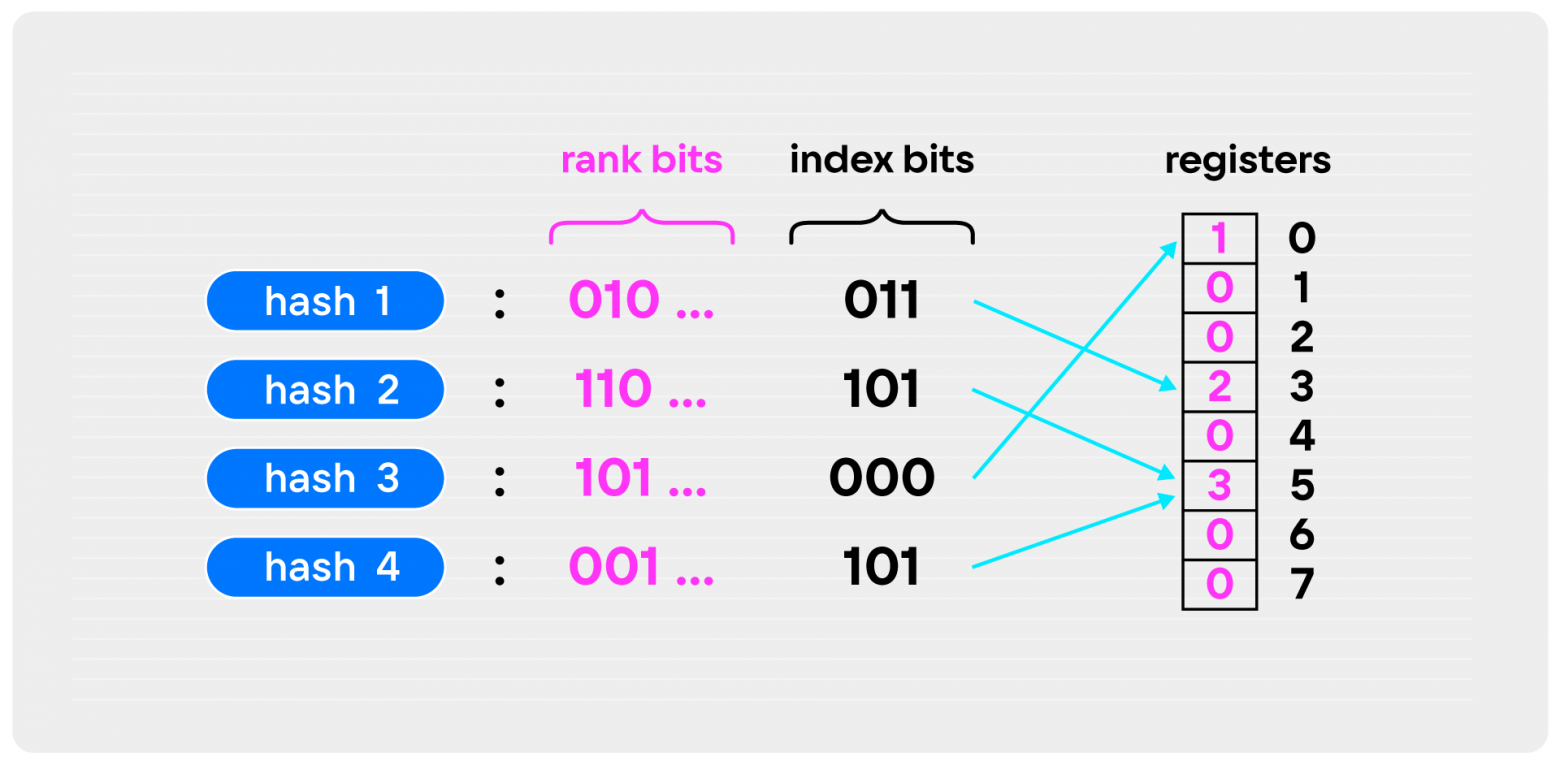
После нахождения максимальных рангов для каждого потока ответ находят в виде
$$
E=\alpha_m \cdot m^2 \cdot \left(\sum_{j=0}^{m-1} 2^{-rank_j}\right)^{-1}
$$
где $m=2^P$ - количество потоков, $\alpha_m$ - корректирующий коэффициент, зависящий от $m$.

#### Немного о способе выбора регистра

Кстати, выбирать в какой поток идет элемент множества казалось бы можно было и просто по очереди, но такой подход сделает результат алгоритма недетерминированным, то есть результат ответа будет зависеть от порядка поступления элементов. Например, алгоритм даст разный результат для одинаковых множеств $A=[a, b, c, d]$ и $B=[b, c, a, d]$.

Кроме того, повторяющиеся элементы множества будут попадать в разные регистры, что нарушет логику алгоритма.

И выбор регистра при помощи битов хэша также позволяет равномерно распределить данные, они независимы ни от чего (от порядка поступления данных).

### Применение Linear Counting при малых множествах

HyperLogLog хорошо работает при большом количестве данных. Но если их мало, стоит использовать корректировку. Для этого используют Linear Counting. Авторы HyperLogLog предлагают делать проверку, что если $E < (5/2)m$, то надо оценивать
$$
E=m\cdot\log(\frac{m}{V})
$$
где $V$ - количество регистров, для которых не было найдено элементов.

### Применение сета при очень малых множествах

Так как в задаче требуется точность не менее 5%, даже Linear Counting, будучи вероятностной структурой данных, дает ошибки на малых множествах. Поэтому можно ввести прямой подсчет мощности множества с помощью сета строк. Строка в сете занимает следующее количество памяти
$$
\text{Объем памяти}=49+\text{длина строки}\cdot\text{вес символа (в байтах)}
$$
где 49 байт - фиксиированое количество памяти для строки в сете, а вес символа 1 байт в ASCII и 2-4 байта в Unicode.
<br>
Кроме самой строки для каждого элемента в сете нужно 32 или 64 байта (в зависимости от разрядности системы) для хранения доп информации для работы хэш-таблицы. В итоге вес одного элемента строки в сете от $81+32 \cdot len(s)\cdot 1$ до $113+64 \cdot len(s) \cdot 4$ байт. В этой заадче говорят, что строки не превышают длины в 1000 символов, так что максимальный вес одного элемента $256113$ байт или $250$ КБ. Но так как неизвестен реальный размер объекта сета для каждого теста, я просто буду заполнять его до тех пор, пока он не превышает ограничения по объему.
<br>
Также как вариант, хранить в сете хэши строк, а не сами строки, так как они занимают всего по 36 Б (см. раздел выше "стандартные решения через сет"). Тогда можно будет хранить до $(500\cdot 1024 / 36) \cdot \frac{2}{3}=9481$ элементов.

# Код

Генерируем случайный набор слов.

In [3]:
import random

def gen_words():
    k = int(random.uniform(1, 10)) #количество повторов слова
    l = int(random.uniform(6, 15)) #длина слова
    word = ''
    for i in range(l):
        word += chr(97 + int(random.uniform(0, 25)))
    words = ''
    for i in range(k):
        words += word + '\n'
    return words

f = open('224input.txt', 'w')
n = 50000
for i in range(n):
    f.write(gen_words())
f.close()

Проверяем какой ответ. Он не обязательно равен n из кода выше, так как возможно совпадение слов при случайной генерации.

In [12]:
s = set()
f = open('224input.txt', 'r')
n = int(f.readline())
for i in range(n):
    s.add(f.readline())
print(len(s))
f.close()

50000


Используем на созданном тесте HyperLogLog.

In [17]:
import math
import sys

class HyperLogLog:
    def __init__(self, precision):
        self.p = precision #точность
        self.m = 1 << self.p #количество потоков
        self.registers = [0] * self.m
        self.small_set = set()
        self.small_set_limit = 490 * 1024 #ставлю ограничение на объём сета в 490 КБ (по условию задачи не более 500 КБ оперативной памяти)

    '''
    64-bit version of popular hash function fnv1a
    '''
    def _fnv1a_64(self, s):
        hash_value = 0xcbf29ce484222325  # FNV_offset_basis - константа для 64-bit
        fnv_prime = 0x100000001b3  # FNV_prime - константа для 64-bit
        for byte in s.encode('utf-8'):
            hash_value ^= byte
            hash_value *= fnv_prime
            hash_value &= 0xFFFFFFFFFFFFFFFF  # Убедимся, что результат остается 64-bit. Похоже, что это как деление по модулю
        return hash_value

    '''
    Функция считает количество нулей в начале хэша
    '''
    def _rho(self, w): #название функции - греческая буква "ро"
        if w == 0:
            return 64
        return 66 - bin(w).find('1')

    def add(self, s):
        if sys.getsizeof(self.small_set) < self.small_set_limit and s not in self.small_set:
            self.small_set.add(s)
        h = self._fnv1a_64(s) #получаем 64-битный хэш строки
        register = h >> (64 - self.p) #получаем индекс потока из первых (левых) p битов хэша
        w = h & ((1 << (64 - self.p)) - 1) #оставшаяся часть хэша
        rank = self._rho(w)
        self.registers[register] = max(self.registers[register], rank)

    def estimate(self):
        if sys.getsizeof(self.small_set) < self.small_set_limit: #для очень малых множеств
            return len(self.small_set)
        alpha = 0.7213 / (1 + 1.079 / self.m)
        E = alpha * self.m**2 / sum(2**(-rank) for rank in self.registers)
        if E <= (5 / 2) * self.m: #волшебная Linear Counting корректировка для малых множеств
            V = self.registers.count(0)
            if V > 0:
                E = self.m * math.log(self.m / V)
        elif E > (1 / 30) * 2**64: #волшебная корректировка для больших множеств
            E = -(2**64) * math.log(1 - E / (2**64))
        return E

f = open('224input.txt')
n = int(f.readline())
hll = HyperLogLog(17)
for i in range(n):
    s = f.readline()
    hll.add(s)
print(hll.estimate())
f.close()

50016.75469305985


## Примечание по решению

$\text{len}(\text{bin}(w)) - \text{bin}(w)\text{.rfind}('1') - 1$ - вот так в функции _rho считать (нули в конце, а не в начале) было неправильно. Так мне предложил считать чатГПТ, но с таким подсчетом ответ выходил неверный. Я не знаю почему, ведь по сути с этой формулой мы считаем количество нулей справа, а не слева. То есть существует половина двоичных чисел, кончающихся на один 0, и половина, начинающихся на один 0 и так далее. И вероятность получения числа с одним 0 в конце равна вероятности получения числа с одним 0 в начале. Но очевидно, что с "левым" подходом мы в одном регистре имеем непрерывный диапазон чисел (для 64-битного случая и одного 0 в начале этот диапазон $[2^{62};2^{63}-1]$), а с "правым" подходом имеем в таком же регистре каждое число, кратное 2. И это говорит о том, что числа не рядом друг с другом. Это все числа, что кратны 2, но не кратны остальным степеням двойки. Есть подозрение, что дело в связи логарифма в HyperLogLog с редкостью числа, а именно с ведущими нулями числа из одного регистра соответсвуют логарифму. Короче, наверное надо почитать оригинал статьи по этой структуре данных.